In [2]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from time import process_time

import keras
from keras import layers
from keras.models import Sequential
import pathlib
import os
import tensorflow as tf
import pickle
import keras_cv
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

2024-06-01 12:43:15.313432: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 12:43:15.316986: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 12:43:15.543289: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-01 12:43:16.284399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 12:43:18.236998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [3]:
# Parameters for LBP
RADIUS = 2
N_POINTS = 8 * RADIUS

In [3]:
# Function to extract LBP features
def extract_lbp_features(image, radius, points):
    lbp = local_binary_pattern(image, points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

# Function to load images and labels from directories
def load_dataset(data_dir):
    images = []
    labels = []
    label_names = os.listdir(data_dir)
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                images.append(image)
                labels.append(label)
    return images, labels

In [7]:
def eval_model(model, X_train, Y_train, X_test, Y_test, desc):
    time1 = process_time()
    pred_train = model.predict(X_train)
    time2 = process_time()
    print("Train Inference time: "+ str(time2 - time1))
    fig = plt.figure(figsize=[25, 12])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, 
                                                 display_labels= ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
                                                 normalize='true', ax=ax)
    conf.ax_.set_title('Model1 ' + desc + ': Train F1 Score ' + str(f1_score(Y_train,pred_train,average='micro')))
    
    ax = fig.add_subplot(1, 2, 2)
    time3 = process_time()
    pred = model.predict(X_test)
    time4 = process_time()
    print("Test Inference time: "+ str(time4 - time3))
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, 
                                                 display_labels = ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'],
                                                 normalize='true', ax=ax)
    conf.ax_.set_title('Model1 '+ desc + ': Test F1 Score ' + str(f1_score(Y_test,pred,average='micro')))
    print('Test Accuracy: ' + str(sum(pred == Y_test)/len(Y_test)))

In [5]:
# Load dataset
data_dir = "./train/train"
train_X, train_Y = load_dataset(data_dir)

partly cloudy


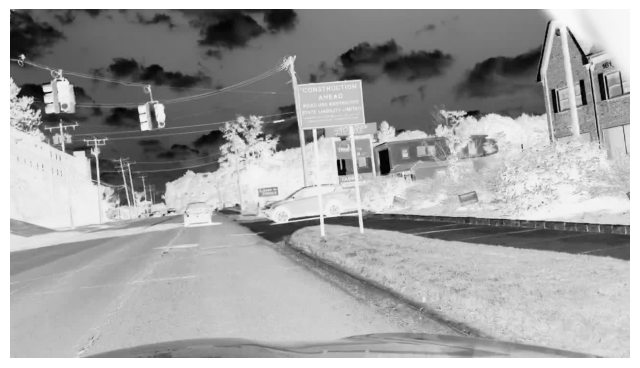

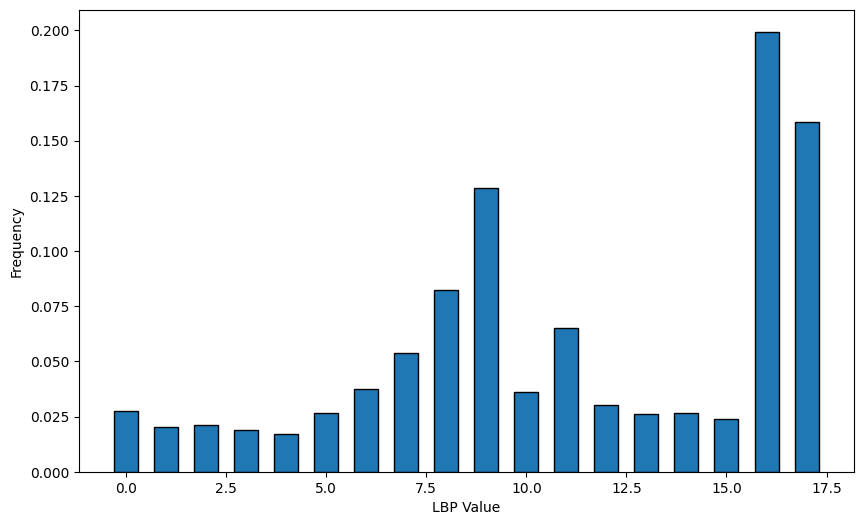

In [9]:
#Drawing histogram
fig = plt.figure(figsize=[8, 8])
for i in range(10,11):
    ax = fig.add_subplot(1, 1,1)
    ax.imshow(train_X[i], cmap=plt.get_cmap('Greys'))
    #ax.set_title('Image in gray scale')
    ax.axis('off')
    print(train_Y[i])

    hist = extract_lbp_features(train_X[i], RADIUS, N_POINTS)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(hist)), hist, width=0.6, edgecolor='black')
    #plt.title('LBP Image')
    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')
    plt.show()
    break


In [7]:
# Extract LBP features from images
time_1 = process_time()
features_train = []
for image in train_X:
    hist = extract_lbp_features(image, RADIUS, N_POINTS)
    features_train.append(hist)

features_train = np.array(features_train)
labels_train = np.array(train_Y)

# Encode labels
le = LabelEncoder()
labels_encoded_train = le.fit_transform(labels_train)
time_2 = process_time()

In [10]:
print(features_train.shape)
print(labels_train.shape)

(7088, 18)
(7088,)


In [7]:
# Load test dataset
data_dir = "./test"
test_X, test_Y = load_dataset(data_dir)

In [ ]:
# Val dataset
data_dir = "./val"
val_X, val_Y = load_dataset(data_dir)

In [8]:
# Extract LBP features from test images
features_test = []
for image in test_X:
    hist = extract_lbp_features(image, RADIUS, N_POINTS)
    features_test.append(hist)

features_test = np.array(features_test)
labels_test = np.array(test_Y)

# Encode labels
le = LabelEncoder()
labels_encoded_test = le.fit_transform(labels_test)

In [9]:
print(features_test.shape)
print(labels_encoded_test.shape)

(340, 18)
(340,)


In [10]:
#Model
svm = SVC(C=1,kernel="linear",class_weight = 'balanced',random_state=41)
svm.fit(features_train,labels_encoded_train)

SVC(C=1, class_weight='balanced', kernel='linear', random_state=41)

In [16]:
y_pred = svm.predict(features_test)
y_pred_train = svm.predict(features_train)

accuracy_train = accuracy_score(labels_encoded_train, y_pred_train)
accuracy_test = accuracy_score(labels_encoded_test, y_pred)

print(f"Accuracy training: {accuracy_train * 100:.2f}%")
print(f"Accuracy testing: {accuracy_test * 100:.2f}%")

print("Classification report for training")

print(classification_report(labels_encoded_train, svm.predict(features_train), target_names=le.classes_))
print("Classification report for testing")
print(classification_report(labels_encoded_test, y_pred, target_names=le.classes_))

Accuracy training: 43.06%
Accuracy testing: 42.06%
Classification report for training
               precision    recall  f1-score   support

partly cloudy       0.41      0.62      0.50       516
        rainy       0.45      0.68      0.54       516
        snowy       0.25      0.01      0.02       538

     accuracy                           0.43      1570
    macro avg       0.37      0.44      0.35      1570
 weighted avg       0.37      0.43      0.35      1570

Classification report for testing
               precision    recall  f1-score   support

partly cloudy       0.41      0.61      0.49       112
        rainy       0.44      0.63      0.52       112
        snowy       0.33      0.03      0.06       116

     accuracy                           0.42       340
    macro avg       0.39      0.43      0.36       340
 weighted avg       0.39      0.42      0.35       340



Test Accuracy: 0.42058823529411765


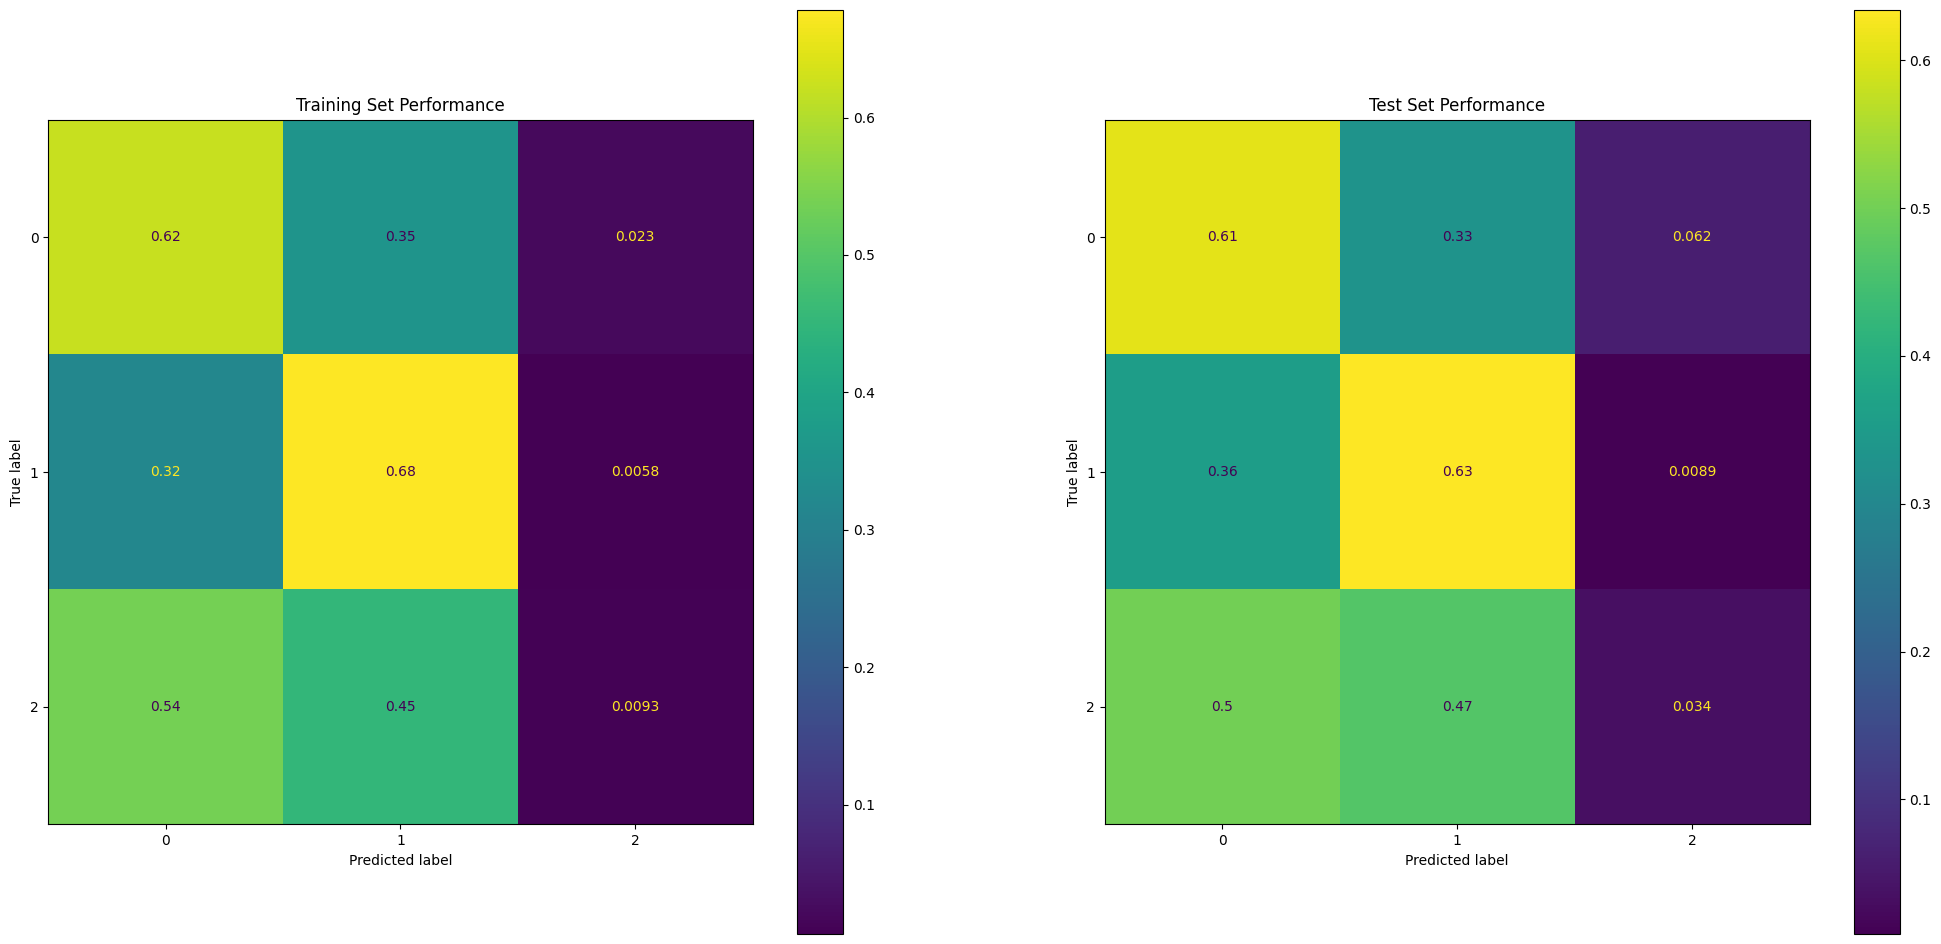

In [13]:

eval_model(svm, features_train, labels_encoded_train, features_test, labels_encoded_test) 

Test Accuracy: 0.5352941176470588


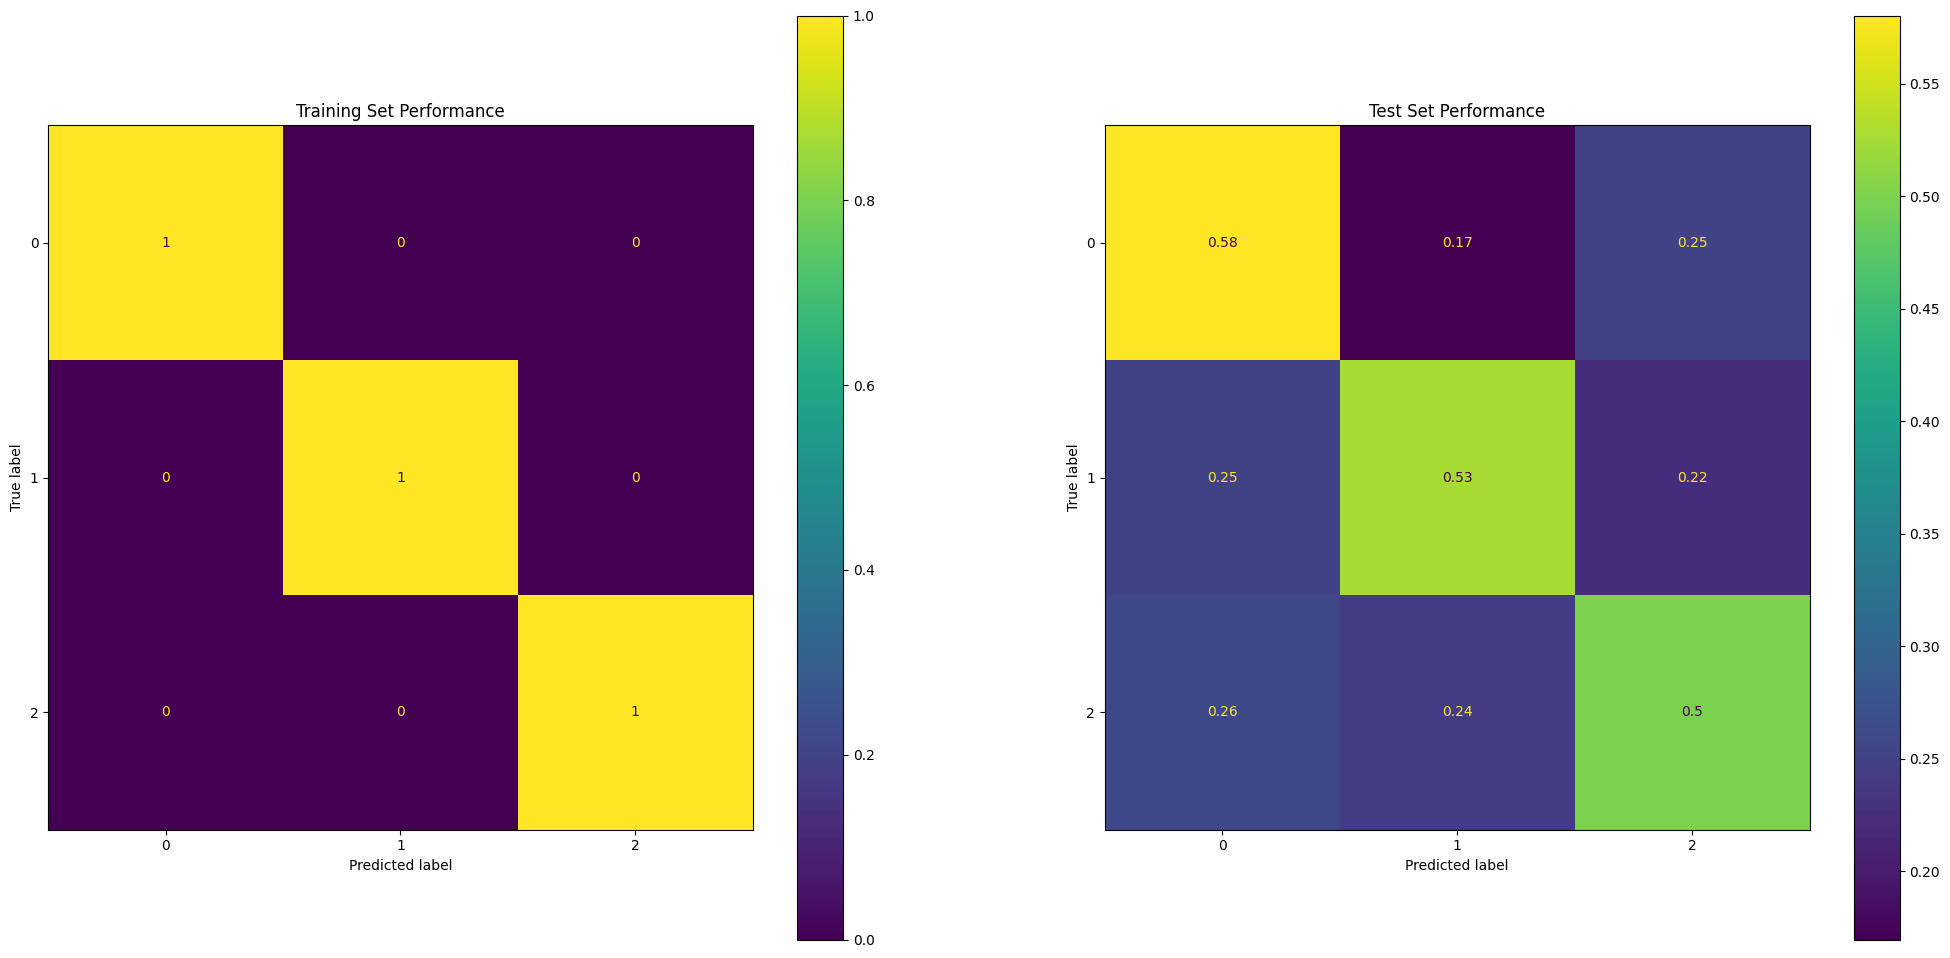

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=41, class_weight="balanced")
rf.fit(features_train, labels_encoded_train)


eval_model(rf, features_train, labels_encoded_train, features_test, labels_encoded_test) 

In [18]:
y_pred = rf.predict(features_test)
y_pred_train = rf.predict(features_train)

accuracy_train = accuracy_score(labels_encoded_train, y_pred_train)
accuracy_test = accuracy_score(labels_encoded_test, y_pred)

print(f"Accuracy training: {accuracy_train * 100:.2f}%")
print(f"Accuracy testing: {accuracy_test * 100:.2f}%")

print("Classification report for training")

print(classification_report(labels_encoded_train, rf.predict(features_train), target_names=le.classes_))
print("Classification report for testing")
print(classification_report(labels_encoded_test, y_pred, target_names=le.classes_))

Accuracy training: 100.00%
Accuracy testing: 53.53%
Classification report for training
               precision    recall  f1-score   support

partly cloudy       1.00      1.00      1.00       516
        rainy       1.00      1.00      1.00       516
        snowy       1.00      1.00      1.00       538

     accuracy                           1.00      1570
    macro avg       1.00      1.00      1.00      1570
 weighted avg       1.00      1.00      1.00      1570

Classification report for testing
               precision    recall  f1-score   support

partly cloudy       0.53      0.58      0.55       112
        rainy       0.56      0.53      0.54       112
        snowy       0.52      0.50      0.51       116

     accuracy                           0.54       340
    macro avg       0.54      0.54      0.54       340
 weighted avg       0.54      0.54      0.53       340



Test Accuracy: 0.42058823529411765


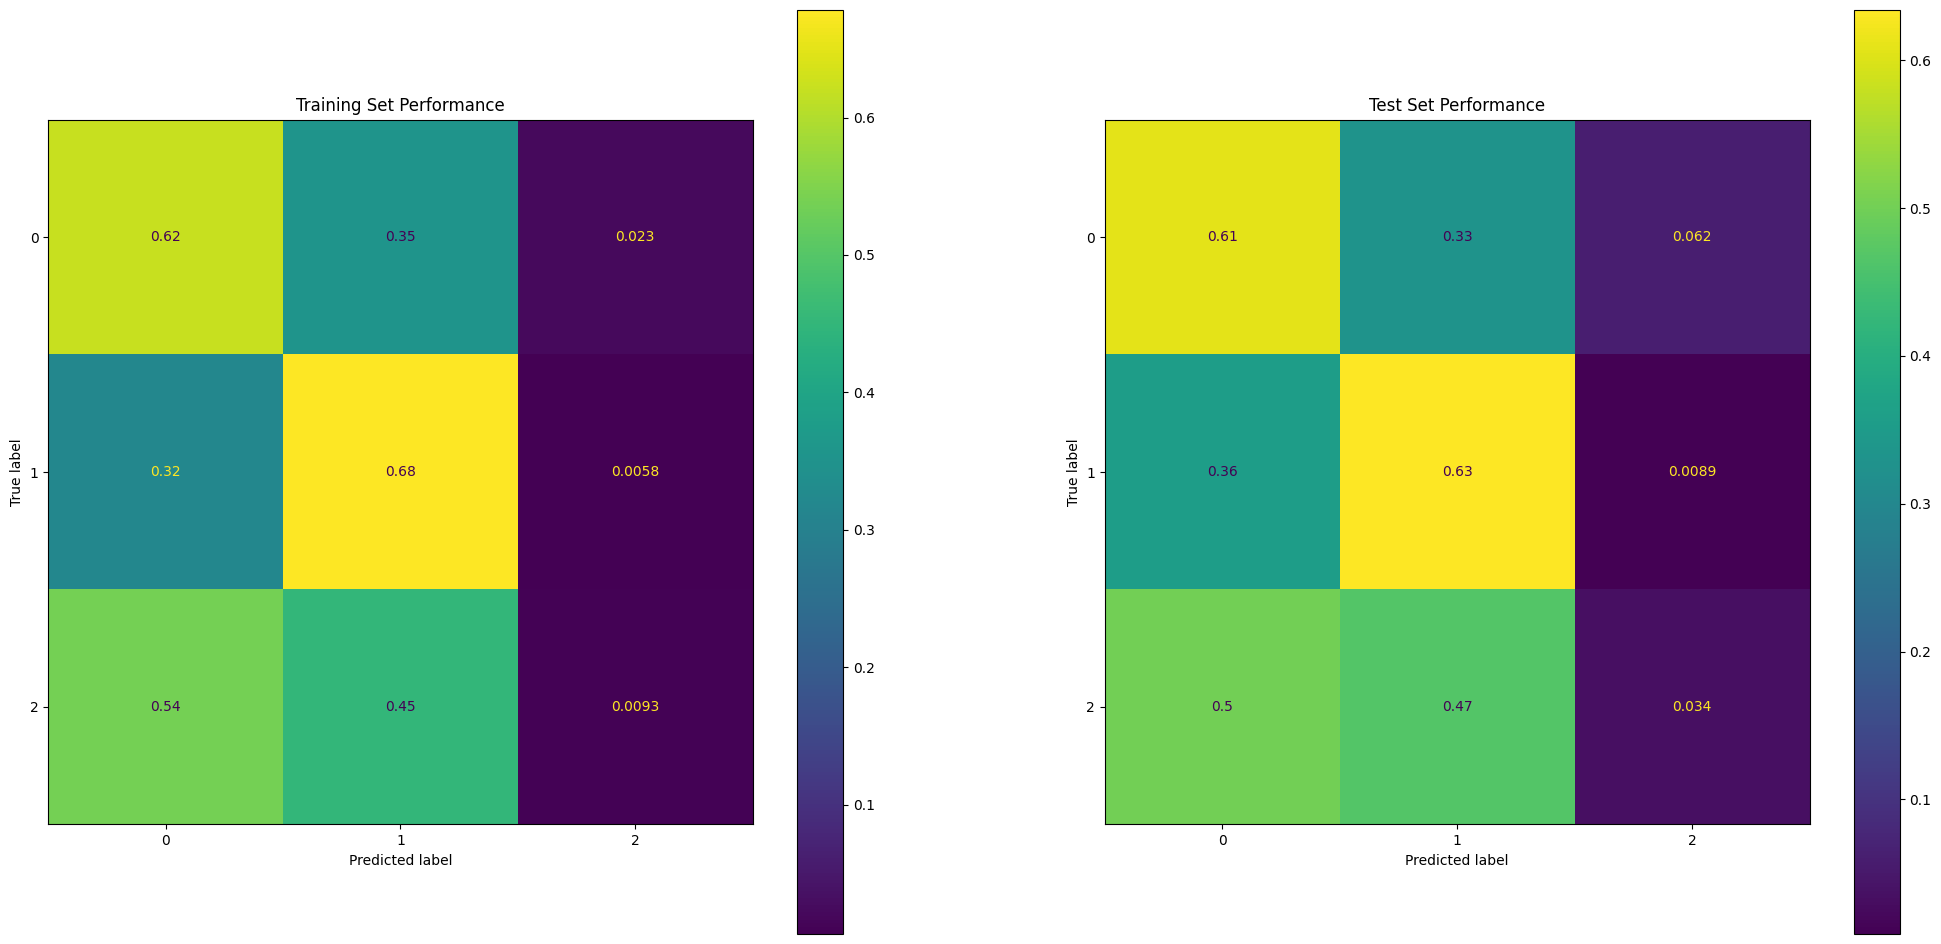

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

eval_model(svm, features_train, labels_encoded_train, features_test, labels_encoded_test) 

In [52]:
print(np.unique(labels_train))

['partly cloudy' 'rainy' 'snowy']


### using entire classes

In [5]:
# Load dataset
data_dir = "./train_all"
train_X, train_Y = load_dataset(data_dir)

In [6]:
# Extract LBP features from images
time_1 = process_time()
features_train = []
for image in train_X:
    hist = extract_lbp_features(image, RADIUS, N_POINTS)
    features_train.append(hist)

features_train = np.array(features_train)
labels_train = np.array(train_Y)

# Encode labels
le = LabelEncoder()
labels_encoded_train = le.fit_transform(labels_train)
time_2 = process_time()

In [9]:
time_2-time_1

1762.5355046

In [10]:
print(features_train.shape)
print(labels_train.shape)

(7088, 18)
(7088,)


In [10]:
print(labels_train)

['foggy' 'foggy' 'foggy' ... 'unknown' 'unknown' 'unknown']


In [8]:
# Load test dataset
data_dir = "./test_all"
test_X, test_Y = load_dataset(data_dir)

In [9]:
# Extract LBP features from test images
time_3 = process_time()
features_test = []
for image in test_X:
    hist = extract_lbp_features(image, RADIUS, N_POINTS)
    features_test.append(hist)

features_test = np.array(features_test)
labels_test = np.array(test_Y)

# Encode labels
le = LabelEncoder()
labels_encoded_test = le.fit_transform(labels_test)
time_4 = process_time()

In [15]:
time_4-time_3

330.9595259

In [9]:
print(features_test.shape)
print(labels_encoded_test.shape)

(1527, 18)
(1527,)


In [11]:
print(labels_encoded_test)

[1 1 1 ... 6 6 6]


In [13]:
from sklearn.model_selection import GridSearchCV
params = [
    {'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150],
    'max_depth': [8, 10, 12, 14, 16,18, 20, 22, 24, 26, 20]}
]
grid = GridSearchCV(estimator=RandomForestClassifier(class_weight = 'balanced', random_state = 12),
             param_grid=params,
             scoring = 'f1_micro')

In [14]:
grid.fit(features_train, labels_encoded_train)
print(grid.best_params_, grid.best_score_, grid.best_estimator_)

{'max_depth': 22, 'n_estimators': 150} 0.5822521806036512 RandomForestClassifier(class_weight='balanced', max_depth=22, n_estimators=150,
                       random_state=12)


In [10]:
time_5 = process_time()
rf = RandomForestClassifier(n_estimators=150, random_state=12, max_depth=22, class_weight="balanced")
rf.fit(features_train, labels_encoded_train)
time_6 = process_time()

In [11]:
time_6 - time_5

4.572863700000198

Train Inference time: 0.16514539999980116
Test Inference time: 0.035832700000355544
Test Accuracy: 0.587426326129666


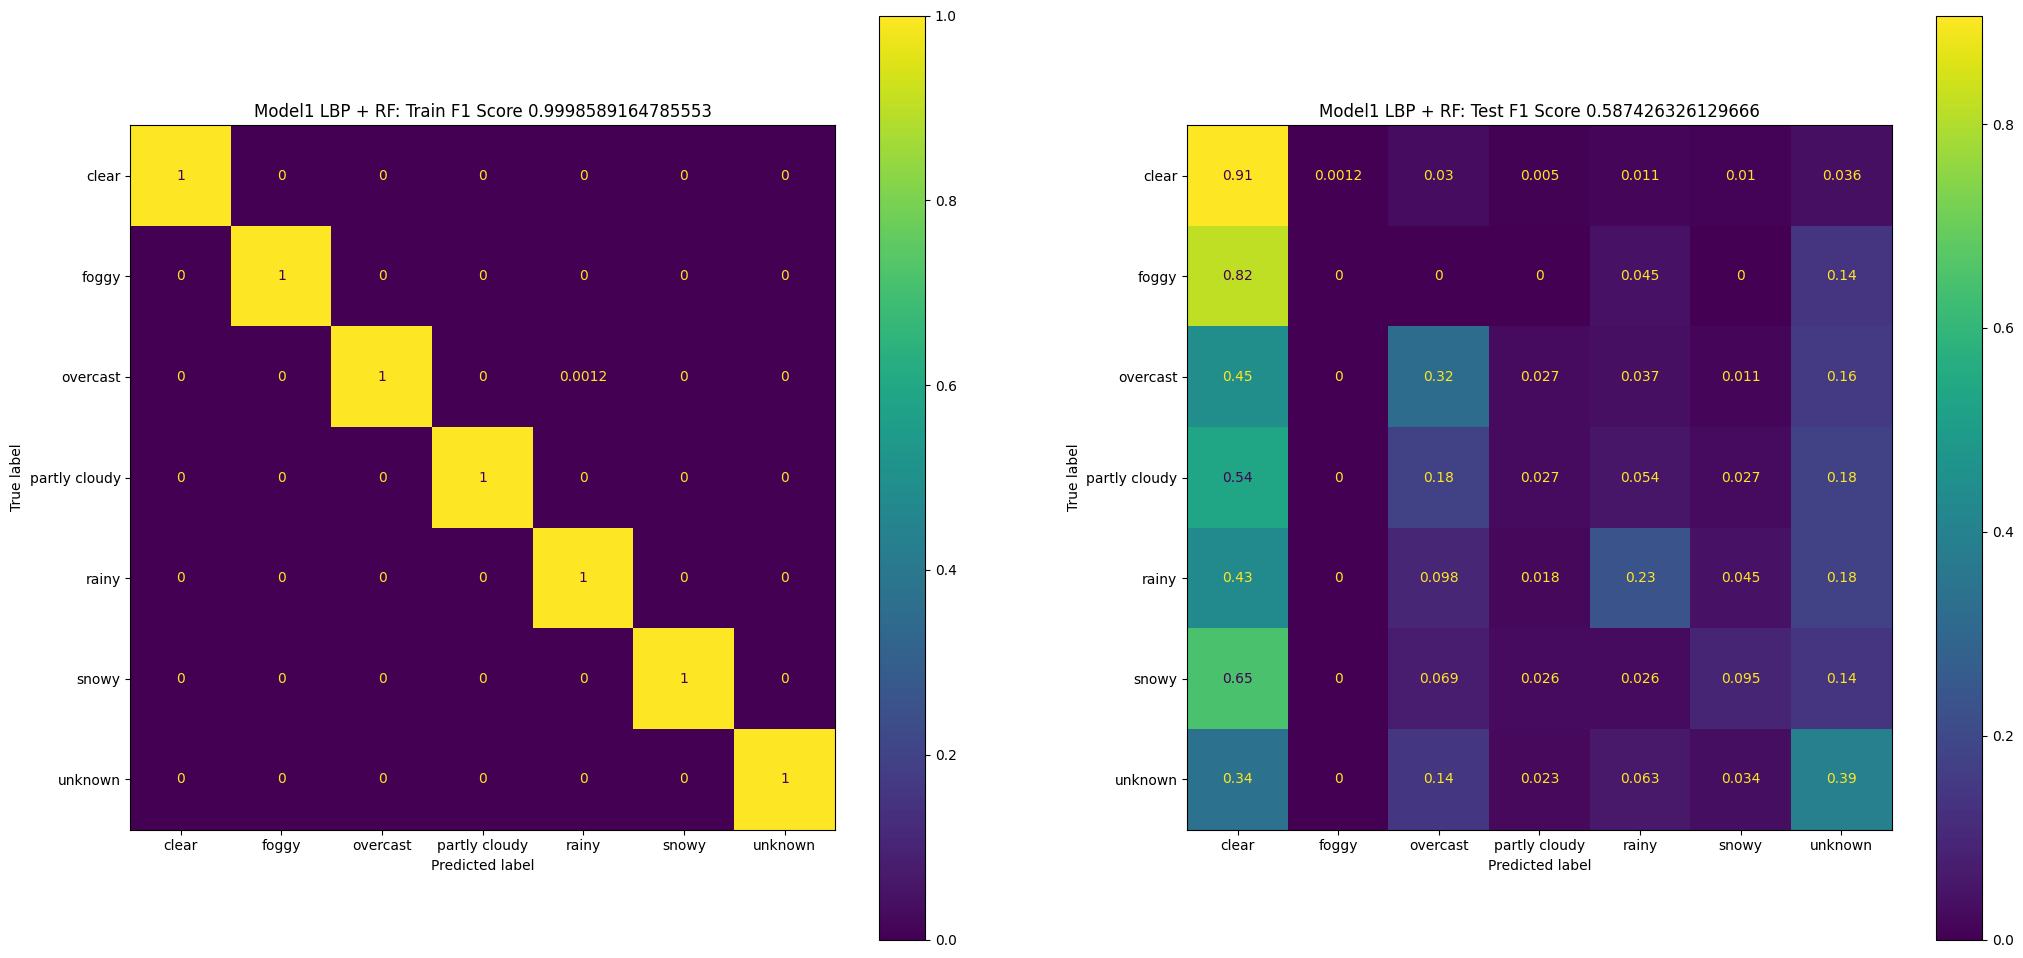

In [12]:
time_7 = process_time()
eval_model(rf, features_train, labels_encoded_train, features_test, labels_encoded_test,"LBP + RF") 
time_8 = process_time()

In [18]:
time_8 - time_7

0.4707994000000326

In [36]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf','sigmoid']},
  {'C': [1, 10, 100, 1000], 'degree': [3, 4, 5], 'gamma': [0.1, 0.01, 0.001],'kernel': ['poly']},
 ]
grid_cv = GridSearchCV(estimator=SVC(class_weight = 'balanced',random_state=12),
             param_grid=param_grid,
             scoring = 'f1_micro')

In [38]:
grid_cv.fit(features_train, labels_encoded_train)
print(grid_cv.best_params_, grid_cv.best_score_, grid_cv.best_estimator_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'} 0.42649840293116126 SVC(C=1000, class_weight='balanced', gamma=0.1, random_state=12)


Train Inference time: 1.822816899999907
Test Inference time: 0.38538980000021184
Test Accuracy: 0.449901768172888


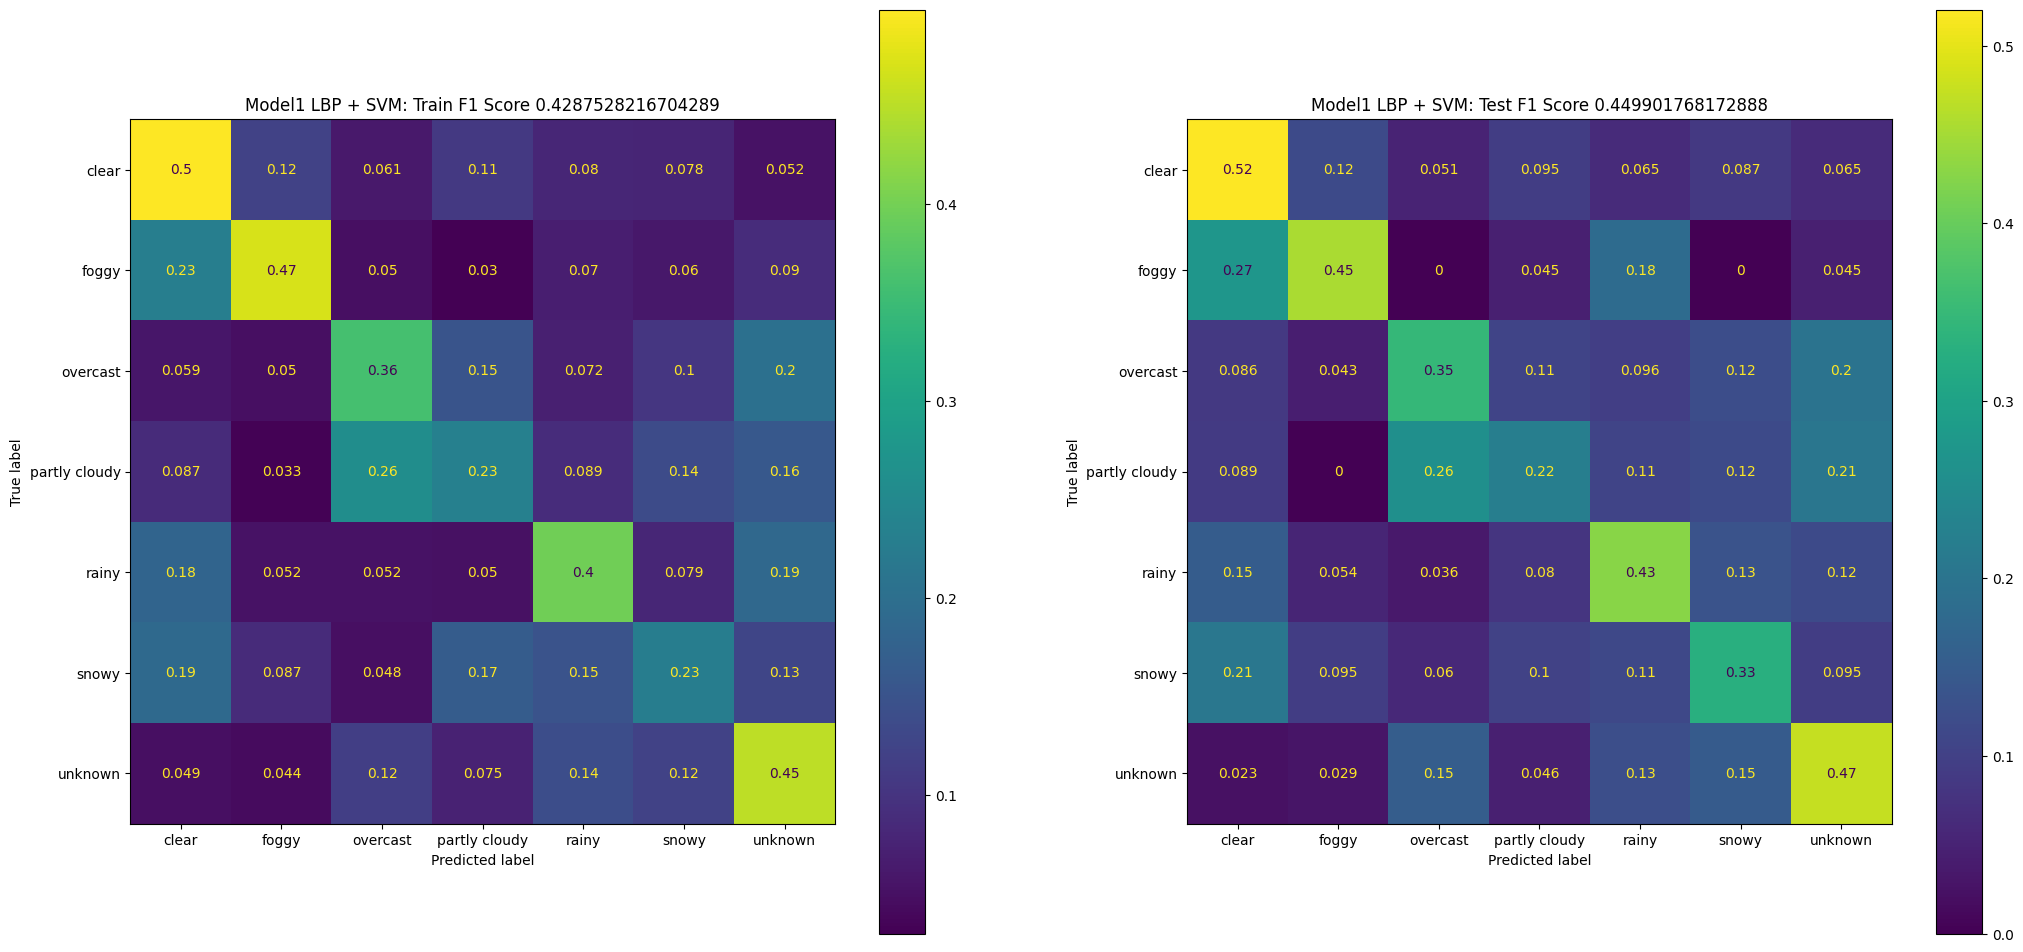

In [13]:
time_9 = process_time()
svm_model = SVC(C= 1000, kernel = "rbf", gamma = 0.1, class_weight = 'balanced',random_state=12)
svm_model.fit(features_train, labels_encoded_train)
time_10 = process_time()

time_9a = process_time()
eval_model(svm_model, features_train, labels_encoded_train, features_test, labels_encoded_test,'LBP + SVM') 
time_10a = process_time()

In [14]:
time_10-time_9

2.3523111999998036

In [21]:
time_10a-time_9a

4.485464100000172

In [39]:
#svm with C=10000
svm = SVC(C=10000,kernel="linear",class_weight = 'balanced',random_state=41)
svm.fit(features_train,labels_encoded_train)

SVC(C=10000, class_weight='balanced', kernel='linear', random_state=41)

In [13]:
y_pred = svm.predict(features_test)
y_pred_train = svm.predict(features_train)

accuracy_train = accuracy_score(labels_encoded_train, y_pred_train)
accuracy_test = accuracy_score(labels_encoded_test, y_pred)

print(f"Accuracy training: {accuracy_train * 100:.2f}%")
print(f"Accuracy testing: {accuracy_test * 100:.2f}%")

print("Classification report for training")

print(classification_report(labels_encoded_train, svm.predict(features_train), target_names=le.classes_))
print("Classification report for testing")
print(classification_report(labels_encoded_test, y_pred, target_names=le.classes_))

NameError: name 'svm' is not defined

Test Accuracy: 0.4629993451211526


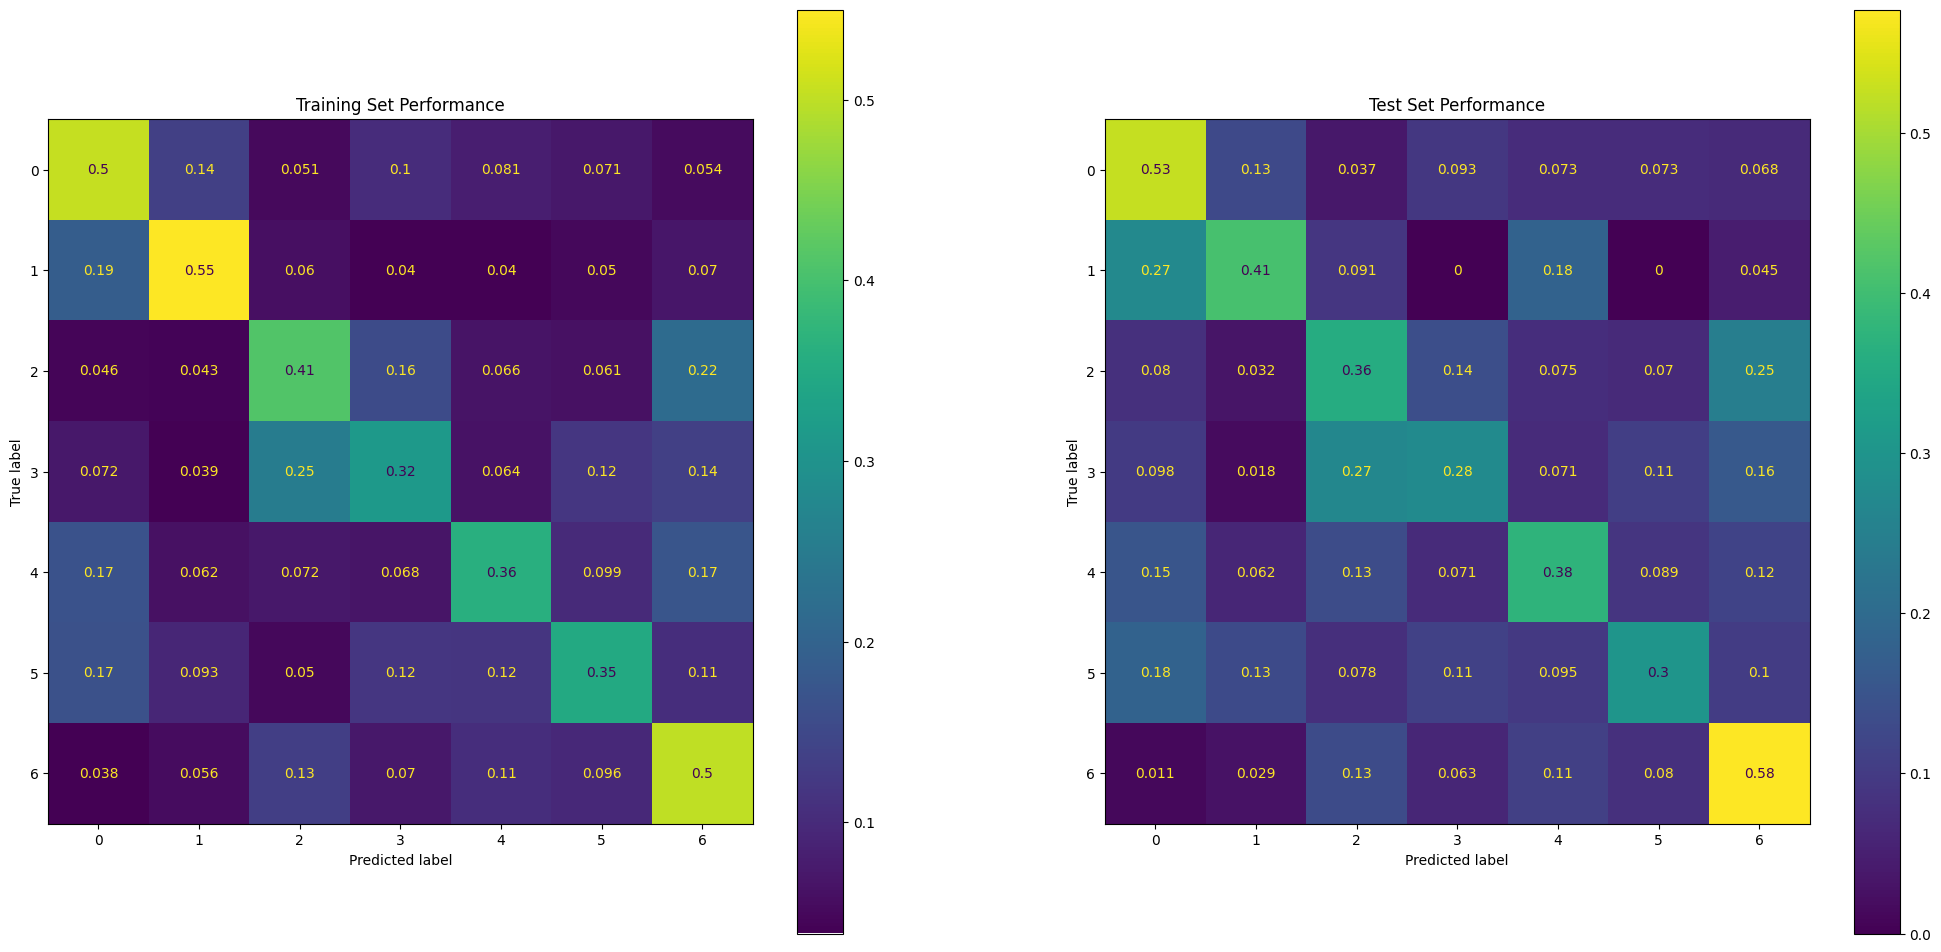

In [36]:
eval_model(svm, features_train, labels_encoded_train, features_test, labels_encoded_test) 

In [40]:
#Svm with c=1000
svm = SVC(C=1000,kernel="linear",class_weight = 'balanced',random_state=41)
svm.fit(features_train,labels_encoded_train)

SVC(C=1000, class_weight='balanced', kernel='linear', random_state=41)

In [16]:
y_pred = svm.predict(features_test)
y_pred_train = svm.predict(features_train)

accuracy_train = accuracy_score(labels_encoded_train, y_pred_train)
accuracy_test = accuracy_score(labels_encoded_test, y_pred)

print(f"Accuracy training: {accuracy_train * 100:.2f}%")
print(f"Accuracy testing: {accuracy_test * 100:.2f}%")

print("Classification report for training")

print(classification_report(labels_encoded_train, svm.predict(features_train), target_names=le.classes_))
print("Classification report for testing")
print(classification_report(labels_encoded_test, y_pred, target_names=le.classes_))

Accuracy training: 42.65%
Accuracy testing: 43.94%
Classification report for training
               precision    recall  f1-score   support

        clear       0.86      0.47      0.61      3742
        foggy       0.06      0.48      0.11       100
     overcast       0.40      0.37      0.38       867
partly cloudy       0.16      0.26      0.20       516
        rainy       0.25      0.41      0.31       516
        snowy       0.20      0.27      0.23       538
      unknown       0.38      0.49      0.42       809

     accuracy                           0.43      7088
    macro avg       0.33      0.39      0.32      7088
 weighted avg       0.59      0.43      0.47      7088

Classification report for testing
               precision    recall  f1-score   support

        clear       0.85      0.50      0.63       803
        foggy       0.06      0.36      0.10        22
     overcast       0.40      0.33      0.36       187
partly cloudy       0.17      0.25      0.20       

Test Accuracy: 0.4394237066142764


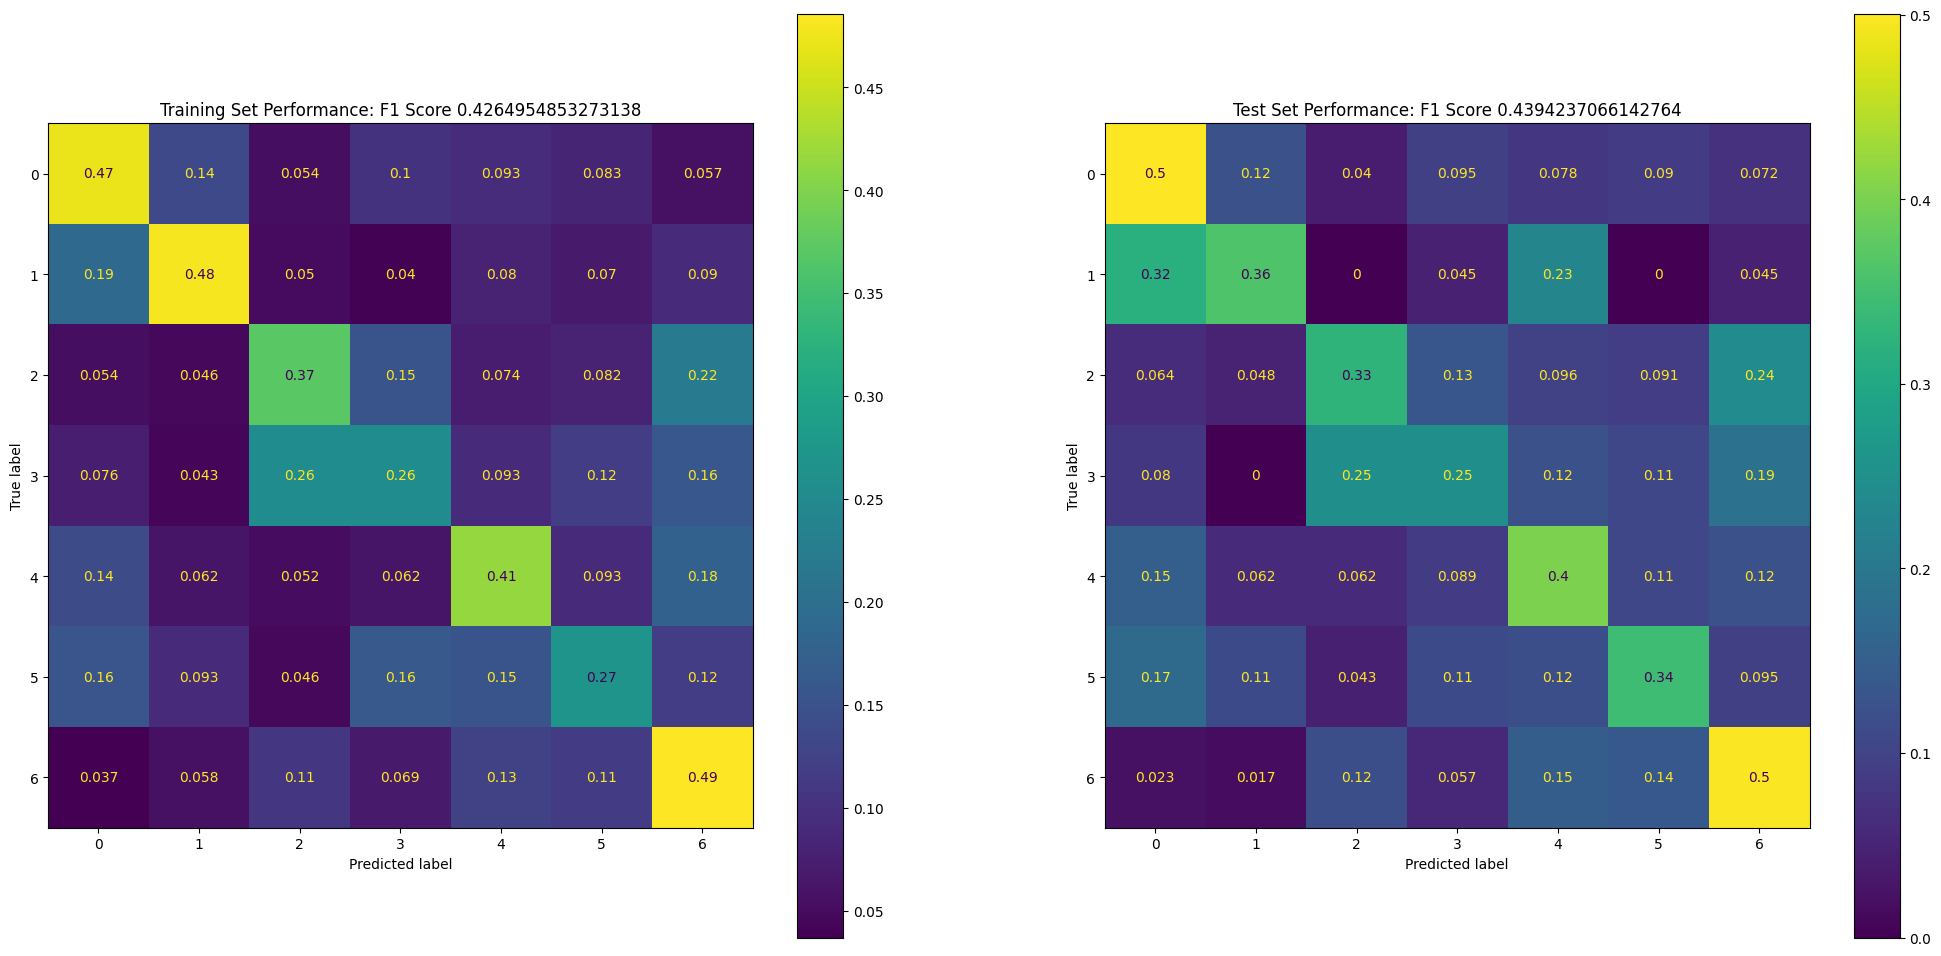

In [41]:
eval_model(svm, features_train, labels_encoded_train, features_test, labels_encoded_test) 

## Using Resnet

In [4]:
# Parameters for LBP
RADIUS = 2
N_POINTS = 8 * RADIUS

# Function to resize image
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

# Function to extract LBP feature map
def create_lbp_feature_map(image, radius, points):
    lbp = local_binary_pattern(image, points, radius, method="uniform")
    return lbp

# Function to load images and labels from directories
def load_dataset(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    label_names = os.listdir(data_dir)
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = resize_image(image, img_size)
                images.append(image)
                labels.append(label)
    return images, labels

# Load dataset
data_dir = './train_all'
images, labels = load_dataset(data_dir)

In [5]:
time_11 = process_time()
# Process images to LBP feature maps for training
lbp_images = [create_lbp_feature_map(img, RADIUS, N_POINTS) for img in images]

# Convert to numpy arrays and reshape for DCN
lbp_images = np.array(lbp_images)
train_X = lbp_images.reshape(lbp_images.shape[0], lbp_images.shape[1], lbp_images.shape[2], 1)

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
train_Y = to_categorical(labels_encoded)

time_12 = process_time()

In [6]:
time_12 - time_11

27.086917199999995

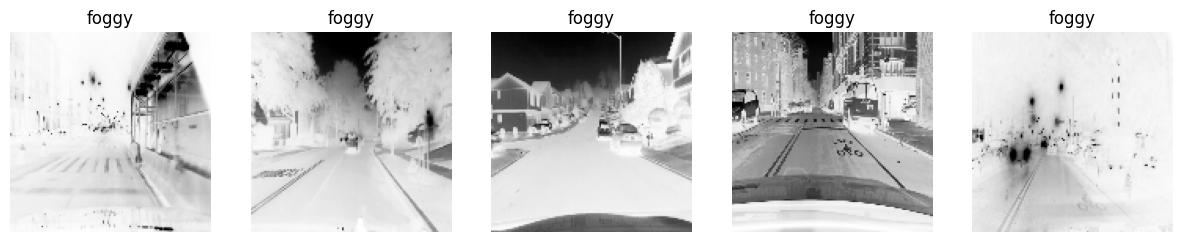

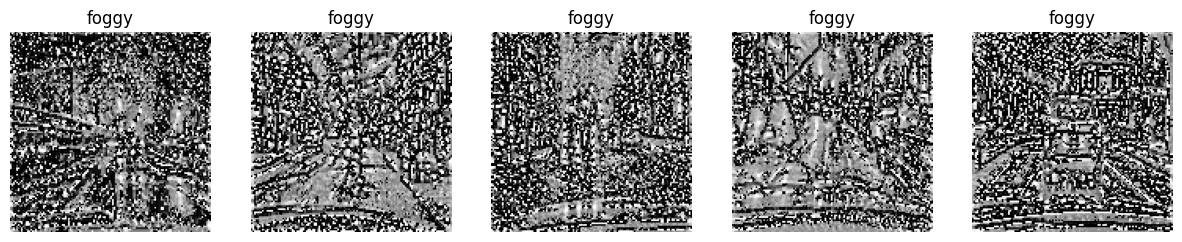

In [7]:
fig = plt.figure(figsize=[15, 18])
for i in range(20,25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(images[i], cmap=plt.get_cmap('Greys'))
    ax.set_title(labels[i])
    ax.axis('off')

fig = plt.figure(figsize=[15, 18])
for i in range(5):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(train_X[i,:], cmap=plt.get_cmap('Greys'))
    ax.set_title(labels[i])
    ax.axis('off')

In [12]:
train_Y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
#To run grayscale images in a pre-trained ResNet-18 model, you need to convert the grayscale images to a format that the ResNet-18 model expects
#train_X = np.repeat(train_X[..., np.newaxis], 3, -1)
#print(train_X.shape)  

In [7]:
#loading validation data
data_dir = './val'
images_val, labels_val = load_dataset(data_dir)

time_13 = process_time()
# Process images to LBP feature maps for training
lbp_images_val = [create_lbp_feature_map(img, RADIUS, N_POINTS) for img in images_val]

# Convert to numpy arrays and reshape for DCN
lbp_images_val = np.array(lbp_images_val)
val_X = lbp_images_val.reshape(lbp_images_val.shape[0], lbp_images_val.shape[1], lbp_images_val.shape[2], 1)

# Encode labels
le = LabelEncoder()
labels_val_encoded = le.fit_transform(labels_val)
val_Y = to_categorical(labels_val_encoded)

time_14 = process_time()
val_X.shape

(1515, 128, 128, 1)

In [ ]:
time_14-time_13

In [8]:
# our model, input again, still in an image shape
inputs = keras.Input(shape=(128, 128, 1, ), name='img')
# run pairs of conv layers, all 3s3 kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
# batch normalisation, before the non-linearity
x = layers.BatchNormalization()(x)
# spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
# than dropping out 20% of the invidual pixels
x = layers.SpatialDropout2D(0.2)(x)
# max pooling, 2x2, which will downsample the image
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# rinse and repeat with 2D convs, batch norm, dropout and max pool
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
# flatten layer
x = layers.Flatten()(x)
# we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
# in the middle
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# the output
outputs = layers.Dense(7, activation='softmax')(x)

# build the model, and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='weather_cnn_model')
model_cnn.summary()

Model: "weather_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 128, 128, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)       │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)       │        584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 128, 128, 8)       │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d               │ (None, 128, 128, 8)       │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 64, 64, 16)        │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_1             │ (None, 64, 64, 16)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)        │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_2             │ (None, 32, 32, 32)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 32768)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 256)               │  8,388,864 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 7)                 │        455 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 8,424,031 (32.14 MB)

 Trainable params: 8,423,919 (32.13 MB)

 Non-trainable params: 112 (448.00 B)

In [10]:
# Input shape
input_data = keras.Input(shape=(224, 224, 1), name='img')

# Pretrained backbone
backbone = keras_cv.models.ResNetBackbone.from_preset("resnet18")

# Pass the input data through the backbone
backbone_output = backbone(input_data)

# Custom layers
x = layers.Flatten()(backbone_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

# Create the full model
model = Model(inputs=input_data, outputs=outputs)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ res_net_backbone                │ (None, 7, 7, 512)         │ 11,186,112 │
│ (ResNetBackbone)                │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 25088)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │  3,211,392 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 7)                 │        455 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,406,215 (54.96 MB)

 Trainable params: 14,396,615 (54.92 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [11]:
model_cnn.compile(
        # categorical cross entropy loss
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
        # adam optimiser
        optimizer=keras.optimizers.Adam(),
        # compute the accuracy metric, in addition to the loss 
        metrics=['accuracy'], jit_compile=False)

time_15 = process_time()
history = model_cnn.fit(
    train_X, train_Y,
    batch_size=64,
    epochs=20,
    validation_data=(val_X,val_Y),
    verbose=True,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)]
)
time_16 = process_time()

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 274ms/step - accuracy: 0.6322 - loss: 1.0721 - val_accuracy: 0.5861 - val_loss: 1.2117
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 28s 256ms/step - accuracy: 0.6756 - loss: 0.9467 - val_accuracy: 0.5439 - val_loss: 1.3986
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 30s 272ms/step - accuracy: 0.6885 - loss: 0.9061 - val_accuracy: 0.5769 - val_loss: 1.2951
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 315ms/step - accuracy: 0.7342 - loss: 0.7939 - val_accuracy: 0.5762 - val_loss: 1.3628
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 334ms/step - accuracy: 0.7552 - loss: 0.6931 - val_accuracy: 0.5776 - val_loss: 1.2793
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 279ms/step - accuracy: 0.7773 - loss: 0.6519 - val_accuracy: 0.5815 - val_loss: 1.3443
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 275ms/step - accuracy: 0.8025 - loss: 0.5576 - val_accuracy: 0.5670 - val_loss: 1.5300
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 30s 271ms/step - accuracy: 0.8223 - loss: 0

In [10]:
time_16 - time15

NameError: name 'time15' is not defined

In [12]:
#loading validation data
data_dir = './test_all'
images_test, labels_test = load_dataset(data_dir)
time_17 = process_time()

# Process images to LBP feature maps for training
lbp_images_test = [create_lbp_feature_map(img, RADIUS, N_POINTS) for img in images_test]

# Convert to numpy arrays and reshape for DCN
lbp_images_test = np.array(lbp_images_test)
test_X = lbp_images_test.reshape(lbp_images_test.shape[0], lbp_images_test.shape[1], lbp_images_test.shape[2], 1)

# Encode labels
le = LabelEncoder()
labels_test_encoded = le.fit_transform(labels_test)
test_Y = to_categorical(labels_test_encoded)

time_18 = process_time()

test_X.shape

(1527, 128, 128, 1)

In [14]:
time_18-time_17

4.8805193999996845

              precision    recall  f1-score   support

           0       0.63      0.93      0.75       803
           1       1.00      0.05      0.09        22
           2       0.39      0.26      0.31       187
           3       0.29      0.14      0.19       112
           4       0.05      0.01      0.02       112
           5       0.11      0.01      0.02       116
           6       0.48      0.36      0.41       175

    accuracy                           0.58      1527
   macro avg       0.42      0.25      0.25      1527
weighted avg       0.48      0.58      0.50      1527



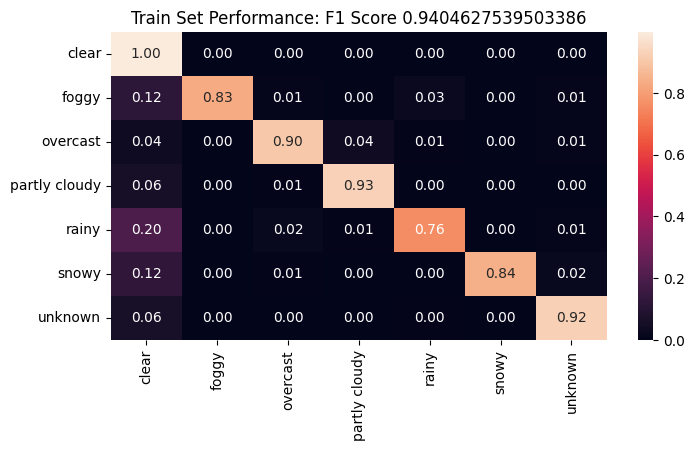

<Figure size 800x800 with 0 Axes>

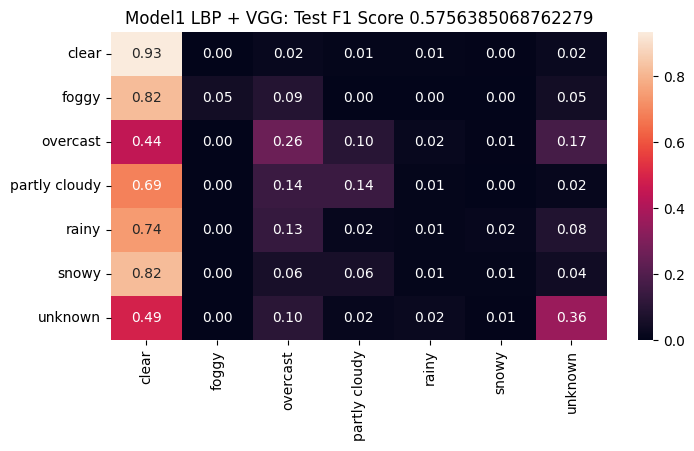

<Figure size 800x800 with 0 Axes>

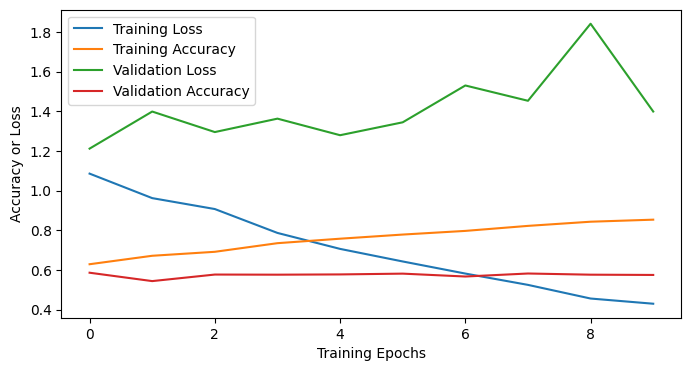

In [13]:
import seaborn as sns

def eval_model(model, history, x_train,y_train, x_test, y_test):

    pred = model.predict(x_train, verbose=False);
    indexes = keras.ops.argmax(pred, axis=1)
    gt_idx = keras.ops.argmax(y_train, axis=1)
    
    cm = confusion_matrix(gt_idx, indexes,normalize='true')
    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, 
            annot=True, fmt='.2f',
            xticklabels=['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
            yticklabels= ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
            ax=ax)
    ax.set_title('Train Set Performance: F1 Score ' + str(f1_score(gt_idx,indexes,average='micro')))

    pred_test = model.predict(x_test, verbose=False);
    indexes_test = keras.ops.argmax(pred_test, axis=1)
    gt_idx_test = keras.ops.argmax(y_test, axis=1)
    
    cm_test = confusion_matrix(gt_idx_test, indexes_test, normalize='true')
    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_test, 
            annot=True, fmt='.2f',
            xticklabels=['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
            yticklabels= ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
            ax=ax)
    ax.set_title('Model1 LBP + VGG: Test F1 Score ' + str(f1_score(gt_idx_test,indexes_test,average='micro')))
    
    print(classification_report(gt_idx_test, indexes_test))

    fig = plt.figure(figsize=[8, 4])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history['loss'], label='Training Loss')
    ax.plot(history['accuracy'], label='Training Accuracy')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.set_xlabel('Training Epochs')
    ax.set_ylabel('Accuracy or Loss')
    ax.legend()

eval_model(model_cnn, history.history, train_X, train_Y, test_X, test_Y) 

test loss: 1.4024595022201538
test accuracy: 0.5645055770874023
              precision    recall  f1-score   support

           0       0.57      0.99      0.73       803
           1       0.00      0.00      0.00        22
           2       0.44      0.12      0.19       187
           3       0.80      0.04      0.07       112
           4       0.00      0.00      0.00       112
           5       0.00      0.00      0.00       116
           6       0.55      0.23      0.33       175

    accuracy                           0.56      1527
   macro avg       0.34      0.20      0.19      1527
weighted avg       0.48      0.56      0.45      1527



/home/sreelakshmi/venv/cab420/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sreelakshmi/venv/cab420/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sreelakshmi/venv/cab420/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

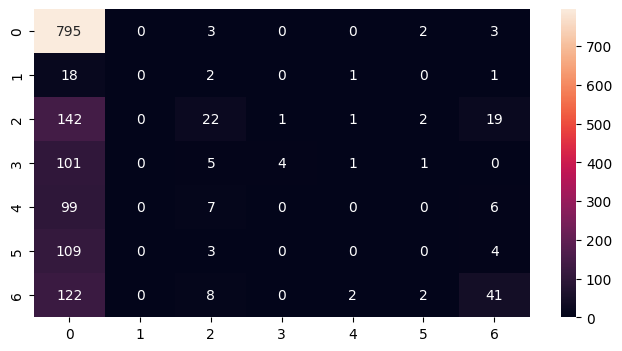

<Figure size 800x800 with 0 Axes>

In [35]:
test_scores = model_cnn.evaluate(test_X, test_Y, verbose=0)
print('test loss:', test_scores[0])
print('test accuracy:', test_scores[1])

pred = model_cnn.predict(test_X, verbose=False);
indexes = keras.ops.argmax(pred, axis=1)
gt_idx = keras.ops.argmax(test_Y, axis=1)

cm = confusion_matrix(gt_idx, indexes)
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, xticklabels=range(7), yticklabels=range(7), 
        annot=True, fmt='g', ax=ax)

print(classification_report(gt_idx, indexes))

Val loss: 1.4202994108200073
Val accuracy: 0.5656765699386597
              precision    recall  f1-score   support

           0       0.58      0.99      0.73       801
           1       0.00      0.00      0.00        21
           2       0.44      0.12      0.19       185
           3       0.60      0.03      0.05       110
           4       0.40      0.02      0.03       110
           5       0.17      0.01      0.02       115
           6       0.50      0.20      0.29       173

    accuracy                           0.57      1515
   macro avg       0.38      0.20      0.19      1515
weighted avg       0.50      0.57      0.45      1515



/home/sreelakshmi/venv/cab420/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sreelakshmi/venv/cab420/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sreelakshmi/venv/cab420/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

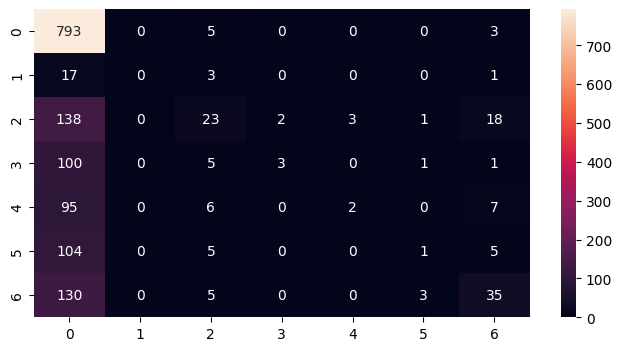

<Figure size 800x800 with 0 Axes>

In [31]:
test_scores = model_cnn.evaluate(val_X, val_Y, verbose=0)
print('Val loss:', test_scores[0])
print('Val accuracy:', test_scores[1])

pred = model_cnn.predict(val_X, verbose=False);
indexes = keras.ops.argmax(pred, axis=1)
gt_idx = keras.ops.argmax(val_Y, axis=1)

cm = confusion_matrix(gt_idx, indexes)
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, xticklabels=range(7), yticklabels=range(7), 
        annot=True, fmt='g', ax=ax)

print(classification_report(gt_idx, indexes))

### Running with 224 x 224 image size without validation

In [3]:
# Parameters for LBP
RADIUS = 2
N_POINTS = 8 * RADIUS

# Function to resize image
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

# Function to extract LBP feature map
def create_lbp_feature_map(image, radius, points):
    lbp = local_binary_pattern(image, points, radius, method="uniform")
    return lbp

# Function to load images and labels from directories
def load_dataset(data_dir, img_size=(224, 224)):
    images = []
    labels = []
    label_names = os.listdir(data_dir)
    for label in label_names:
        label_dir = os.path.join(data_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = resize_image(image, img_size)
                images.append(image)
                labels.append(label)
    return images, labels

# Load dataset
data_dir = './train_all'
images, labels = load_dataset(data_dir)

In [4]:
# Process images to LBP feature maps for training
lbp_images = [create_lbp_feature_map(img, RADIUS, N_POINTS) for img in images]

In [5]:
# Convert to numpy arrays and reshape for DCN
lbp_images = np.array(lbp_images)
train_X = lbp_images.reshape(lbp_images.shape[0], lbp_images.shape[1], lbp_images.shape[2], 1)
train_X.shape

(7088, 224, 224, 1)

In [6]:
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
train_Y = to_categorical(labels_encoded)

In [7]:
# our model, input again, still in an image shape
inputs = keras.Input(shape=(224, 224, 1, ), name='img')
# run pairs of conv layers, all 3s3 kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
# batch normalisation, before the non-linearity
x = layers.BatchNormalization()(x)
# spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
# than dropping out 20% of the invidual pixels
x = layers.SpatialDropout2D(0.2)(x)
# max pooling, 2x2, which will downsample the image
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# rinse and repeat with 2D convs, batch norm, dropout and max pool
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
# flatten layer
x = layers.Flatten()(x)
# we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
# in the middle
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# the output
outputs = layers.Dense(7, activation='softmax')(x)

# build the model, and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='weather_cnn_model')
model_cnn.summary()

Model: "weather_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 224, 224, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 8)       │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 8)       │        584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 224, 224, 8)       │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d               │ (None, 224, 224, 8)       │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 8)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 16)      │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 16)      │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 112, 112, 16)      │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_1             │ (None, 112, 112, 16)      │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 32)        │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_2             │ (None, 56, 56, 32)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 100352)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 256)               │ 25,690,368 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │     16,448 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 7)                 │        455 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 25,725,535 (98.14 MB)

 Trainable params: 25,725,423 (98.13 MB)

 Non-trainable params: 112 (448.00 B)

In [8]:
model_cnn.compile(
        # categorical cross entropy loss
        loss=keras.losses.CategoricalCrossentropy(from_logits=False),
        # adam optimiser
        optimizer=keras.optimizers.Adam(),
        # compute the accuracy metric, in addition to the loss 
        metrics=['accuracy'], jit_compile=False)

history = model_cnn.fit(
    train_X, train_Y,
    batch_size=64,
    epochs=10,
    verbose=True
    #callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, start_from_epoch=3)]
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 85s 701ms/step - accuracy: 0.4167 - loss: 2.8407
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 78s 704ms/step - accuracy: 0.5348 - loss: 1.4667
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 78s 703ms/step - accuracy: 0.5379 - loss: 1.4117
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 85s 762ms/step - accuracy: 0.5512 - loss: 1.3535
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 84s 760ms/step - accuracy: 0.5803 - loss: 1.2443
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 84s 758ms/step - accuracy: 0.5978 - loss: 1.1782
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 87s 785ms/step - accuracy: 0.6379 - loss: 1.0745
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 686ms/step - accuracy: 0.6563 - loss: 1.0024
Epoch 9/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 94s 844ms/step - accuracy: 0.6790 - loss: 0.9405
Epoch 10/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 85s 768ms/step - accuracy: 0.7082 - loss: 0.8845


In [ ]:
pred = model_cnn.predict(train_X, verbose=False);
indexes = keras.ops.argmax(pred, axis=1)
gt_idx = keras.ops.argmax(train_Y, axis=1)

cm = confusion_matrix(gt_idx, indexes, normalise='True')
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(1, 1, 1)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, 
            annot=True, fmt='g',
            xticklabels=['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
            yticklabels= ['clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'unknown'], 
            ax=ax)
ax_.set_title('Train Set Performance: F1 Score ' + str(f1_score(gt_idx,indexes,average='micro')))
print(classification_report(gt_idx, indexes))

fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(1, 1, 1)
ax.plot(history['loss'], label='Training Loss')
ax.plot(history['accuracy'], label='Training Accuracy')
ax.plot(history['val_loss'], label='Validation Loss')
ax.plot(history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Training Epochs')
ax.set_ylabel('Accuracy or Loss')

ax.legend()